## Color Generator Model Using Keras Neural Network
In this notebook, I'll implement a recursive neural network (RNN) using keras package, this model will take words and generate a color related to this word. We will start by Tokenize the words in our dataframe to a character level, then one-hot encoding it, and finally training our network. This notebook is build following the same procedure as Tony607 from his Github repository and his blog post, the links are provided at the end of this notebook.

### 1- Importing Packages

In [2]:
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils
import json
import io

import scipy.stats as stats
import pylab as plt
import numpy as np
import pandas as pd


### 2- Loading Dataset

In [3]:
df = pd.read_csv('../data/final_dataset.csv')
df.head()

,word,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130


### 3- Tokenizing the Words to a Character level
When feeding data to neural network, the data must be in a numerical format, either integers or floats, the network can't understand strings and characters. To solve this, we will perform what something called Tokenizing. Tokenizing is like encrypting each word to a number, however we will encrypt each litter to a number, so we will have a total of 28 numbers that represents each letter. More and better explanation is provided in the blog post linked at the end of this notebook.

In [4]:
#saving our words in a time series
words = df["word"]
#sorting the words with respect to length and save it to numpy array
h = sorted(words.str.len())
#checking the max of length of our words
np.array(h).max()

30

In [10]:
maxlen = np.array(h).max()
#initialising the tokenizer with character level enabeled 
t = Tokenizer(char_level=True)
#fitting the tokenizer to our words
t.fit_on_texts(words)
#saving the tekonized words
tokenized = t.texts_to_sequences(words)
#turn it to a 2d numpy arrays
padded_words = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
#let's take a look
padded_words.shape

(31612, 30)

### 4- One-hot Encoding

In [11]:
one_hot_words = np_utils.to_categorical(padded_words)
num_classes = one_hot_words.shape[-1]
num_classes

28

In [12]:
#checking the shape
one_hot_words.shape

(31612, 30, 28)

In [13]:
#taking a look at the encryption (our dictionary)
t.word_index

{'e': 1,
 'a': 2,
 'r': 3,
 'i': 4,
 'n': 5,
 'o': 6,
 's': 7,
 'l': 8,
 't': 9,
 ' ': 10,
 'c': 11,
 'u': 12,
 'd': 13,
 'm': 14,
 'g': 15,
 'p': 16,
 'h': 17,
 'b': 18,
 'y': 19,
 'w': 20,
 'f': 21,
 'k': 22,
 'v': 23,
 'z': 24,
 'q': 25,
 'j': 26,
 'x': 27}

### 5- Normalizing the color values
Our RGB color format ranges from 0 to 255, It's always a better approach to normalize values to be from 0 to 1 when feeding it to neural networks.

In [14]:
# The RGB values are between 0 - 255
# scale them to be between 0 - 1
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(df["red"]), norm(df["green"]), norm(df["blue"])])

### 6- RNN Model
We can finally define and train our RNN model, the training takes around 45 mins, you can skip the training and just load the weights and jump the prediction section. The network consists of 4 layers, two LSTM layers, one dense relu layer, and one dense sigmoid layer. The used optimizer is adam and the metric is MSE. We didn't perform test, train split but we used a validation of 0.1 for each epoch. after We also performed a training with the full set without validation, to feed our network with as most words as possible.

In [15]:
#defining our model
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, num_classes)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 256)           291840    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 505,859
Trainable params: 505,859
Non-trainable params: 0
_________________________________________________________________


In [16]:
#load the model if you don't want to wait for the training 
model.load_weights('RNN_model.h5')

In [17]:
#training the model, this will take more than 30 mins be aware
history = model.fit(one_hot_words, normalized_values,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.1)

Epoch 1/30
445/445 [==============================] - 92s 196ms/step - loss: 0.0347 - acc: 0.7370 - val_loss: 0.0828 - val_acc: 0.6199
Epoch 2/30
445/445 [==============================] - 85s 190ms/step - loss: 0.0340 - acc: 0.7411 - val_loss: 0.0864 - val_acc: 0.6085
Epoch 3/30
445/445 [==============================] - 85s 191ms/step - loss: 0.0338 - acc: 0.7436 - val_loss: 0.0872 - val_acc: 0.5832
Epoch 4/30
445/445 [==============================] - 90s 202ms/step - loss: 0.0337 - acc: 0.7452 - val_loss: 0.0895 - val_acc: 0.5952
Epoch 5/30
445/445 [==============================] - 94s 211ms/step - loss: 0.0336 - acc: 0.7474 - val_loss: 0.0896 - val_acc: 0.5892
Epoch 6/30
445/445 [==============================] - 87s 195ms/step - loss: 0.0335 - acc: 0.7471 - val_loss: 0.0905 - val_acc: 0.5857
Epoch 7/30
445/445 [==============================] - 86s 194ms/step - loss: 0.0334 - acc: 0.7494 - val_loss: 0.0922 - val_acc: 0.6056
Epoch 8/30
445/445 [==============================] - 8

In [18]:
# Optionally continue to train with all data and no validation
model.fit(one_hot_words, normalized_values,
                    epochs=10,
                    batch_size=62)

Epoch 1/10
510/510 [==============================] - 79s 155ms/step - loss: 0.0390 - acc: 0.7461
Epoch 2/10
510/510 [==============================] - 79s 156ms/step - loss: 0.0387 - acc: 0.7463
Epoch 3/10
510/510 [==============================] - 80s 156ms/step - loss: 0.0385 - acc: 0.7481
Epoch 4/10
510/510 [==============================] - 81s 158ms/step - loss: 0.0384 - acc: 0.7453
Epoch 5/10
510/510 [==============================] - 80s 157ms/step - loss: 0.0383 - acc: 0.7491
Epoch 6/10
510/510 [==============================] - 80s 157ms/step - loss: 0.0383 - acc: 0.7478
Epoch 7/10
510/510 [==============================] - 80s 157ms/step - loss: 0.0382 - acc: 0.7519
Epoch 8/10
510/510 [==============================] - 81s 158ms/step - loss: 0.0382 - acc: 0.7523
Epoch 9/10
510/510 [==============================] - 80s 156ms/step - loss: 0.0381 - acc: 0.7504
Epoch 10/10
510/510 [==============================] - 77s 151ms/step - loss: 0.0381 - acc: 0.7514


In [19]:
# Saving the model that we've trained.
model.save_weights('RNN_model.h5')

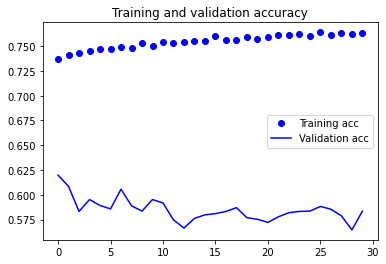

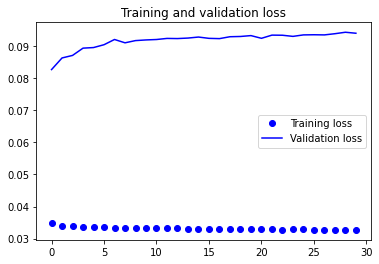

In [20]:
#taking a look at the accuracy of our model

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


We got around 75% accuracy for the training and around 60% for the validation but it wasn't very stable, I believe the model can be improved with some modification in the data and maybe small changes to the network structure, yet this result is OK for now and I'll proceed to try the model with some words.

### 7- Predicting Using the Model (Generating Colors)

In [22]:
#defining the methods that we need

# Plot a color image.
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

#scaling to reverse the normalisation we did before
def scale(n):
    return int(n * 255) 

#method to return the color in a tuple format (r, g, b)
def predict_color(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=30)
    one_hot = np_utils.to_categorical(padded, num_classes=28)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    return r, g, b

#method to return a plotted color generated by our model
def predict_plot(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded, num_classes=num_classes)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred) 

This is the best part for me, let's try and generate some colors

red, R,G,B: 197 43 37


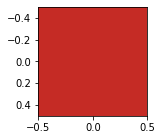

green, R,G,B: 90 167 67


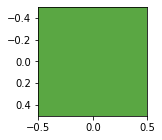

blue, R,G,B: 68 124 188


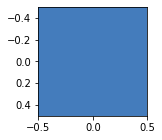

yellow, R,G,B: 249 239 132


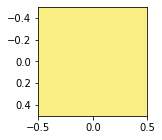

purple, R,G,B: 149 68 173


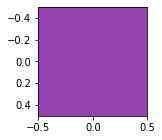

In [24]:
#normal colors
predict_plot("red")
predict_plot("green")
predict_plot("blue")
predict_plot("yellow")
predict_plot('purple')

light blue, R,G,B: 181 218 238


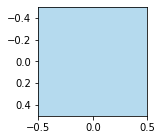

dark blue, R,G,B: 5 16 106


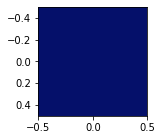

navy blue, R,G,B: 9 32 87


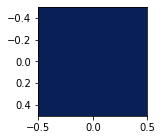

In [28]:
#shades of blue
predict_plot("light blue")
predict_plot("dark blue")
predict_plot("navy blue")

autumn, R,G,B: 152 95 52


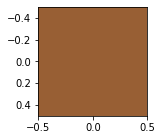

winter, R,G,B: 133 156 168


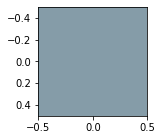

spring, R,G,B: 184 179 166


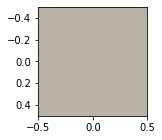

summer, R,G,B: 151 174 157


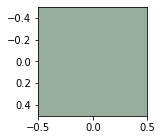

In [29]:
#4 seasons
predict_plot("autumn")
predict_plot("winter")
predict_plot("spring")
predict_plot("summer")

the spring and summer are not close to what we expect for their colors to be

black, R,G,B: 34 31 25


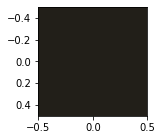

white, R,G,B: 245 243 242


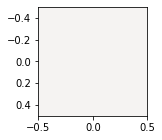

neon, R,G,B: 159 147 136


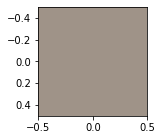

In [30]:
#black, white, and neon
predict_plot("black")
predict_plot("white")
predict_plot("neon")

Neon is also off, I believe this is due to duplicating the same word in the dataset but with different colors, this leads to averaging the colors and something like mixing paint and getting brown at the end.

In [34]:
#checking for spring, summer, and neon in the data set
df[df['word']=='neon'].count()

word     61
red      61
green    61
blue     61
dtype: int64

In [37]:
df[df['word']=='summer'].count()

word     50
red      50
green    50
blue     50
dtype: int64

In [38]:
df[df['word']=='spring'].count()

word     50
red      50
green    50
blue     50
dtype: int64

Having 50 entries and more for the same word with different colors is a way more than needed, a future improvement can be limiting the reputation of any word in the data set to 5 or 10 entries maximum.

coffee, R,G,B: 120 91 64


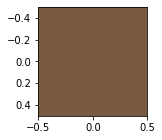

latte, R,G,B: 189 157 96


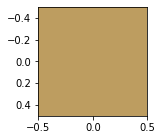

chocolate, R,G,B: 118 88 64


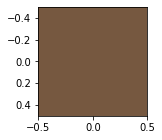

strawberry, R,G,B: 176 86 68


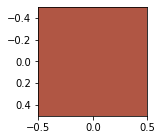

royal, R,G,B: 107 71 118


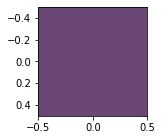

ice cream, R,G,B: 243 229 208


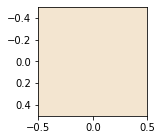

In [39]:
#more colors before completing this notebook
predict_plot("coffee")
predict_plot("latte")
predict_plot("chocolate")
predict_plot("strawberry")
predict_plot("royal")
predict_plot("ice cream")

### 8- Conclusion
Personally speaking, I like the performance of the model, but there is many possibilities for future improvement, such as working more on the dataset, also adding the 2 worded names from the PAT dataset instead of only 1 worded names, and also trying different structures for the neural network. Next step is generating palette using color theory schemes and a GUI. Please refer to the GUI folder to try the GUI program and generating the color palettes.

### 9- Refrences
- Chengwei Zhang (Tony607) blog post:
https://www.dlology.com/blog/how-to-train-a-keras-model-to-generate-colors/

- Tony607 repository:
https://github.com/Tony607/Keras-Colors
